In [ ]:
!sudo apt-get update
!sudo apt-get install -y python3-dev swig
!pip install box2d-py
!pip install --no-cache-dir gym[box2d]
!pip install tensorflow matplotlib


Training Progress:  62%|██████▏   | 3123/5000 [38:01<22:51,  1.37it/s, average_score=253, score=256]


Environment solved in 3124 episodes!


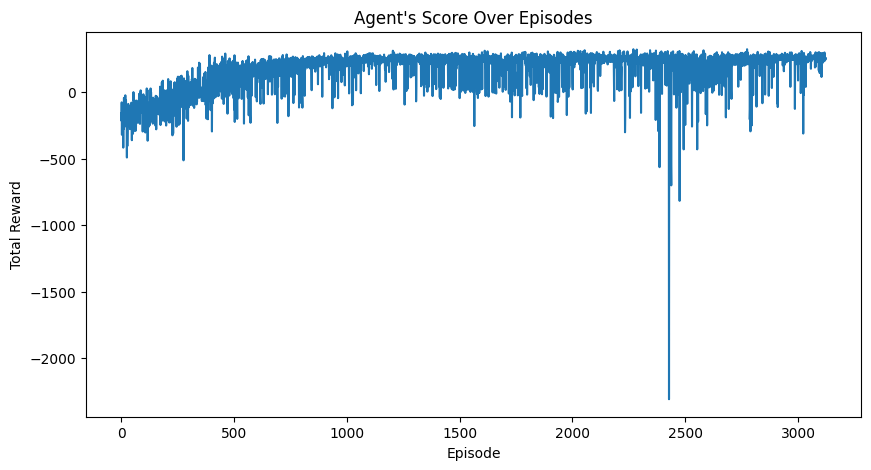

In [2]:
import gym
import torch
import random

import numpy              as np
import torch.nn           as nn
import torch.optim        as optim
import matplotlib.pyplot  as plt

from tqdm                 import trange
from collections          import namedtuple, deque

# Set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DeepQNetwork(nn.Module):
    """
    A class representing the Deep Q-Network (DQN) architecture.

    Attributes:
        layers (torch.nn.Sequential): A sequence of layers comprising the neural network.

    Methods:
        forward(state): Perform a forward pass through the network.
    """

    def __init__(self, state_dim, action_dim, hidden_size=64):
        """
          Initializes the DeepQNetwork with two hidden layers.

          Args:
              state_dim (int): The dimension of the state space.
              action_dim (int): The dimension of the action space.
              hidden_size (int, optional): The size of the hidden layers. Defaults to 64.
          """
        super(DeepQNetwork, self).__init__()

        # Define the layers of the neural network
        self.layers = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim)
        )

    def forward(self, state):
        """
        Perform a forward pass through the network given a state.

        Args:
            state (torch.Tensor): The input state to the network.

        Returns:
            torch.Tensor: The output from the network.
        """
        return self.layers(state)

class Agent:
    """
    A class representing an agent using the Deep Q-Learning algorithm.

    Attributes:
        Several configuration parameters for the agent and DQN.

    Methods:
        select_action(state, epsilon): Selects an action based on the epsilon-greedy policy.
        store_transition(state, action, reward, next_state, done): Stores a transition and possibly triggers a learning step.
        learn_from_experiences(experiences): Learns from a batch of sampled experiences.
        update_target_net(): Performs a soft update of the target network's parameters.
    """

    def __init__(self, state_dim, action_dim, batch_size=128, learning_rate=1e-3, discount_factor=0.99,
                 memory_capacity=int(1e5), update_frequency=5, soft_update_factor=1e-3):
        """
        Initializes the Agent with two Q-Networks and sets up the learning process.

        Args:
            state_dim (int): The dimension of the state space.
            action_dim (int): The dimension of the action space.
            batch_size (int, optional): The mini-batch size for training. Defaults to 128.
            learning_rate (float, optional): The learning rate for the optimizer. Defaults to 1e-3.
            discount_factor (float, optional): The discount factor for future rewards. Defaults to 0.99.
            memory_capacity (int, optional): The capacity of the replay buffer. Defaults to 1e5.
            update_frequency (int, optional): How often to update the network. Defaults to 5.
            soft_update_factor (float, optional): The soft update factor for the target network. Defaults to 1e-3.
        """
         # Initialize agent parameters
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.discount_factor = discount_factor
        self.update_frequency = update_frequency
        self.soft_update_factor = soft_update_factor

        # Initialize the policy and target Q-Networks
        self.policy_net = DeepQNetwork(state_dim, action_dim).to(device)
        self.target_net = DeepQNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.loss_function = nn.MSELoss()

        # Initialize the replay buffer and a counter for update frequency
        self.memory = ReplayBuffer(action_dim, memory_capacity, batch_size)
        self.update_counter = 0

    def select_action(self, state, epsilon):
        """
        Selects an action for the given state using an epsilon-greedy policy.

        Args:
            state (array_like): The current state of the environment.
            epsilon (float): The probability of choosing a random action.

        Returns:
            int: The action chosen by the agent.
        """
        # Convert the state to tensor for network input
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

        # Evaluate the action values with the current policy
        self.policy_net.eval()  # Set the network to evaluation mode
        with torch.no_grad():
            action_values = self.policy_net(state_tensor)
        self.policy_net.train()  # Set the network back to training mode

        # Choose action based on epsilon-greedy policy
        if random.random() < epsilon:
            return random.randrange(self.action_dim)  # Random action
        else:
            return np.argmax(action_values.cpu().data.numpy())  # Greedy action

    def store_transition(self, state, action, reward, next_state, done):
        """
        Stores a transition in the replay buffer and decides whether to trigger learning.

        Args:
            state (array_like): The previous state of the environment.
            action (int): The action taken in the state.
            reward (float): The reward received after taking the action.
            next_state (array_like): The next state of the environment.
            done (bool): A flag indicating whether the episode has ended.
        """
        # Store the transition in the replay buffer
        self.memory.add(state, action, reward, next_state, done)

        # Increment the update counter
        self.update_counter += 1

        # Check if it's time to update the policy network
        if self.update_counter % self.update_frequency == 0 and len(self.memory) >= self.batch_size:
            # Sample a batch of experiences from the memory
            experiences = self.memory.sample()
            # Learn from the sampled experiences
            self.learn_from_experiences(experiences)

    def learn_from_experiences(self, experiences):
        """
        Updates the policy network using a batch of experience tuples.

        Args:
            experiences (tuple): A batch of experience tuples.
        """
        # Unpack experiences
        states, actions, rewards, next_states, dones = experiences

        # Compute Q values for the next states using the target network
        next_state_values = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)

        # Compute the target Q values for the current states
        target_q_values = rewards + self.discount_factor * next_state_values * (1 - dones)

        # Compute the expected Q values from the policy net
        expected_q_values = self.policy_net(states).gather(1, actions)

        # Compute the loss between expected Q values and target Q values
        loss = self.loss_function(expected_q_values, target_q_values)

        # Perform gradient descent
        self.optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagate the loss
        self.optimizer.step()  # Update network weights

        # Update the target network with a soft update
        self.update_target_net()

    def update_target_net(self):
        """
        Soft update of the target network's weights.
        """
        # Update the target network parameters with a mix of policy net parameters
        for policy_param, target_param in zip(self.policy_net.parameters(), self.target_net.parameters()):
            target_param.data.copy_(self.soft_update_factor * policy_param.data + (1.0 - self.soft_update_factor) * target_param.data)

# ReplayBuffer class

class ReplayBuffer:
    """
    A class for storing and sampling experiences for the agent.

    Attributes:
        action_dim (int): The dimension of the action space.
        batch_size (int): The number of experiences to sample from the buffer.
        memory (collections.deque): A double-ended queue to store experiences.
        experience (namedtuple): A named tuple for storing experience data.

    Methods:
        add(state, action, reward, next_state, done): Adds an experience to the buffer.
        sample(): Samples a batch of experiences from the buffer.
        __len__(): Returns the current size of the buffer.
    """
    def __init__(self, action_dim, capacity, batch_size):
        """
        Initializes the ReplayBuffer.

        Args:
            action_dim (int): The dimension of the action space.
            capacity (int): The maximum size of the buffer.
            batch_size (int): The batch size for sampling from the buffer.
        """
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.memory = deque(maxlen=capacity)  # Initialize a deque with fixed capacity
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """
        Adds an experience to the buffer.

        Args:
            state (array_like): The previous state of the environment.
            action (int): The action taken in the state.
            reward (float): The reward received after taking the action.
            next_state (array_like): The next state of the environment.
            done (bool): A flag indicating whether the episode has ended.
        """
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """
        Samples a batch of experiences from the buffer.

        Returns:
            tuple: A batch of experiences, each as a separate array (states, actions, rewards, next_states, dones).
        """
        # Randomly sample a batch of experiences from the buffer
        experiences = random.sample(self.memory, k=self.batch_size)

        # Convert experiences into separate arrays for each component
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([int(e.done) for e in experiences])).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """
        Returns the current size of the buffer.

        Returns:
            int: The number of experiences currently in the buffer.
        """
        return len(self.memory)

# Training and evaluation functions

def train_agent(env, agent, num_episodes=5000, max_timesteps=1000, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995, target_score=250, checkpoint=False):
    """
    Trains the agent in the given environment using Deep Q-Learning.

    Args:
        env (gym.Env): The environment to train the agent in.
        agent (Agent): The agent to train.
        num_episodes (int, optional): The number of episodes to train for. Defaults to 5000.
        max_timesteps (int, optional): The maximum number of timesteps per episode. Defaults to 1000.
        epsilon_start (float, optional): The starting value for epsilon in the epsilon-greedy policy. Defaults to 1.0.
        epsilon_end (float, optional): The minimum value for epsilon. Defaults to 0.1.
        epsilon_decay (float, optional): The decay rate for epsilon after each episode. Defaults to 0.995.
        target_score (float, optional): The average score over 100 episodes to consider the environment solved. Defaults to 250.
        checkpoint (bool, optional): Whether to save a checkpoint of the model after solving the environment. Defaults to False.

    Returns:
        list: A list of total rewards per episode.
    """
    scores = []  # Initialize a list to store the scores of each episode
    epsilon = epsilon_start  # Initialize epsilon for the epsilon-greedy policy

    # Create a progress bar for training display
    progress_bar_format = '{l_bar}{bar:10}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]'
    progress_bar = trange(num_episodes, desc="Training Progress", bar_format=progress_bar_format)

    for episode in progress_bar:
        state = env.reset()  # Reset the environment and get the initial state
        total_reward = 0  # Initialize the total reward for the episode

        for timestep in range(max_timesteps):
            action = agent.select_action(state, epsilon)  # Select an action
            next_state, reward, done, _ = env.step(action)  # Take the action in the environment
            agent.store_transition(state, action, reward, next_state, done)  # Store the transition
            state = next_state  # Update the state
            total_reward += reward  # Update the total reward

            if done:  # If the episode is done, exit the loop
                break

        scores.append(total_reward)  # Append the total reward of the episode to the scores list
        recent_avg_score = np.mean(scores[-100:])  # Calculate the recent average score
        epsilon = max(epsilon_end, epsilon_decay * epsilon)  # Update epsilon

        # Update the progress bar with the current score and the recent average score
        progress_bar.set_postfix(score=total_reward, average_score=recent_avg_score)

        if recent_avg_score >= target_score:  # If the recent average score meets the target, stop training
            print(f"\nEnvironment solved in {episode+1} episodes!")
            if checkpoint:  # If checkpointing is enabled, save the model
                torch.save(agent.policy_net.state_dict(), 'checkpoint.pth')
            break

    return scores  # Return the list of scores

def evaluate_agent(env, agent, num_episodes=3):
    """
    Evaluates the agent's performance in the environment.

    Args:
        env (gym.Env): The environment to evaluate the agent in.
        agent (Agent): The agent to evaluate.
        num_episodes (int, optional): The number of episodes to evaluate the agent for. Defaults to 3.
    """
    for episode in range(num_episodes):  # Evaluate the agent for a certain number of episodes
        state = env.reset()  # Reset the environment and get the initial state
        total_reward = 0  # Initialize the total reward for the episode
        done = False  # Initialize the done flag

        while not done:  # Play the episode until it's done
            action = agent.select_action(state, epsilon=0)  # Choose the best action (greedy)
            state, reward, done, _ = env.step(action)  # Take the action in the environment
            env.render()  # Render the environment
            total_reward += reward  # Update the total reward

        print(f"Episode {episode+1}: Total Reward = {total_reward}")  # Print the total reward for the episode
    env.close()  # Close the environment

def plot_scores(scores):
    """
    Plots the scores of the agent over time.

    Args:
        scores (list): A list of total rewards per episode to plot.
    """
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.plot(scores)  # Plot the scores
    plt.title("Agent's Score Over Episodes")  # Set the title of the plot
    plt.xlabel('Episode')  # Set the x-axis label
    plt.ylabel('Total Reward')  # Set the y-axis label
    plt.show()  # Display the plot

# Main script

# Environment setup
environment = gym.make('LunarLander-v2')  # Create the LunarLander-v2 environment
state_dimensions = environment.observation_space.shape[0]  # Get the state dimensions
action_dimensions = environment.action_space.n  # Get the action dimensions

# Agent setup
agent = Agent(
    state_dim=state_dimensions,
    action_dim=action_dimensions
)

# Train the agent
score_history = train_agent(environment, agent)  # Train the agent and get the score history
plot_scores(score_history)  # Plot the score history

# Clear the GPU cache if CUDA was used
if str(device) == "cuda":
    torch.cuda.empty_cache()  # Clear the GPU cache to free memory
